**The purpose of this notebook is to discover which factors affect the amount of money taken out in loans by small businesses, as well as investigate if the amount taken by a business is related to whether they pay it off or default.**

NOTE: fix sector info. 0 means that NAICS was 0. Mark as unknown, separate from 92 other services?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading in cleaned dataset, finding datatypes and NA values.**

In [2]:
data_path = '/content/drive/MyDrive/Data Science/Project 2/Project 2 Team 3/data/' 
image_path = '/content/drive/MyDrive/Data Science/Project 2/Project 2 Team 3/images/'
df = pd.read_csv(data_path + 'data_with_sectors.csv')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Sector,Description,ID,Name,City,State,Zip,Bank,BankState,NAICS,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Sectornum
0,45.0,Retail trade,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,...,0.0,1.0,NaN,28-Feb-99,60000.0,0.0,$0.00,60000.0,48000.0,45
1,72.0,Accommodation and food services,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,...,0.0,1.0,NaN,31-May-97,40000.0,0.0,$0.00,40000.0,32000.0,72
2,62.0,Health care and social assistance,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,...,0.0,0.0,NaN,31-Dec-97,287000.0,0.0,$0.00,287000.0,215250.0,62
3,NaN,NaN,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,...,0.0,1.0,NaN,30-Jun-97,35000.0,0.0,$0.00,35000.0,28000.0,0
4,NaN,NaN,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,...,0.0,0.0,NaN,14-May-97,229000.0,0.0,$0.00,229000.0,229000.0,0


In [3]:
df.shape

(899164, 29)

In [4]:
df.dtypes

Sector               float64
Description           object
ID                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr            float64
LowDoc               float64
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
MIS_Status           float64
ChgOffPrinGr          object
GrAppv               float64
SBA_Appv             float64
Sectornum              int64
dtype: object

In [5]:
df.isna().sum()

Sector               202177
Description          202177
ID                        0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr            277479
LowDoc                 6007
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
Sectornum                 0
dtype: int64

**There are several factors related to loan amount. SBA_Appv is the amount guaranteed by the Small Business Administration. GrAppv is the loan amount approved by the bank. DisbursementGross is the amount of money actually received by the business. How do these relate to each other?**

In [6]:
print(df['DisbursementGross'].mean(), df['DisbursementGross'].min(), df['DisbursementGross'].max())
print(df['GrAppv'].mean(), df['GrAppv'].min(), df['GrAppv'].max())
print(df['SBA_Appv'].mean(), df['SBA_Appv'].min(), df['SBA_Appv'].max())

201154.0167310969 0.0 11446325.0
192686.97638361857 200.0 5472000.0
149488.78817546077 100.0 5472000.0


In [7]:
print(len(df[df['DisbursementGross'] < 1]))
print(len(df[df['DisbursementGross'] < 1])/df.shape[0] * 100) 
#196 loans were approved but no $ was disbursed
#this is .02% of the entries

196
0.021798025721670354


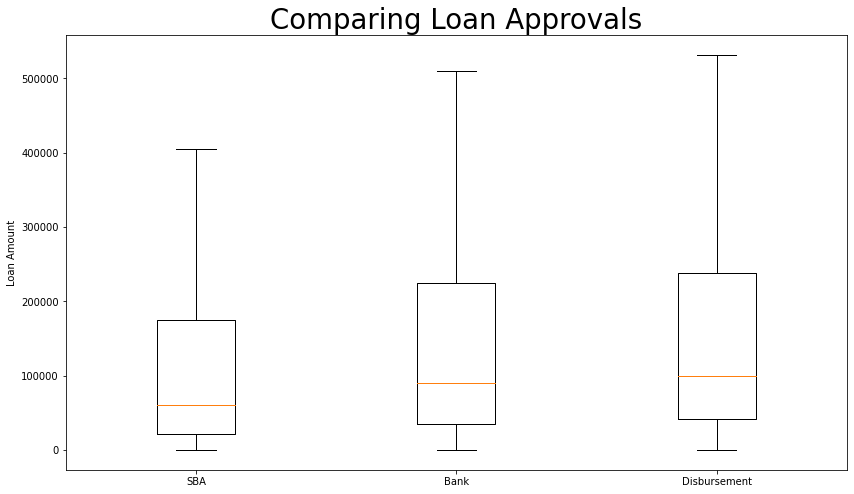

In [8]:
plt.figure(figsize=[14, 8])
plt.boxplot([df['SBA_Appv'], df['GrAppv'], df['DisbursementGross']], showfliers = False)
plt.ticklabel_format(axis='y', style='plain')
plt.xticks([1, 2, 3], ['SBA', 'Bank', 'Disbursement'])
plt.ylabel('Loan Amount')
plt.rc('font', size=23) 
plt.title('Comparing Loan Approvals')
plt.savefig(image_path + 'compare_appv_amts.png')

**We'll use disbursement as our loan amount. Which factors affect this amount? We will compare the following factors for the businesses: urban vs rural, franchise vs non-franchise, new vs existing business, and number of employees. (AND SECTOR?)**

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


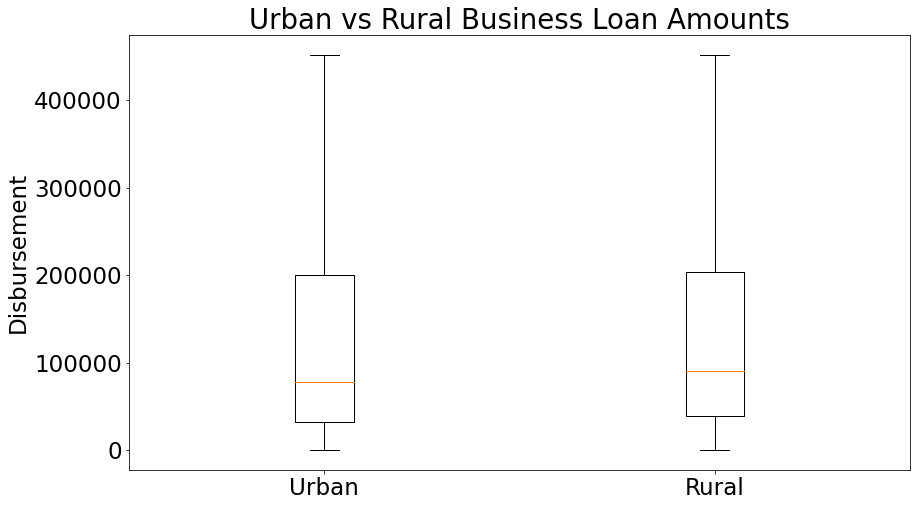

In [9]:
#urban vs rural
df_urban = df[df['UrbanRural'] == 1]
df_rural = df[df['UrbanRural'] == 2]
plt.figure(figsize=[14, 8])
plt.boxplot([df_urban['DisbursementGross'], df_rural['DisbursementGross']], showfliers=False)
plt.xticks([1, 2], ['Urban', 'Rural'])
plt.ylabel('Disbursement')
plt.title('Urban vs Rural Business Loan Amounts')
plt.rc('font', size=30)
plt.savefig(image_path + 'urban_vs_rural_amt.png')

In [10]:
df['UrbanRural'].value_counts()

1    470654
0    323167
2    105343
Name: UrbanRural, dtype: int64

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


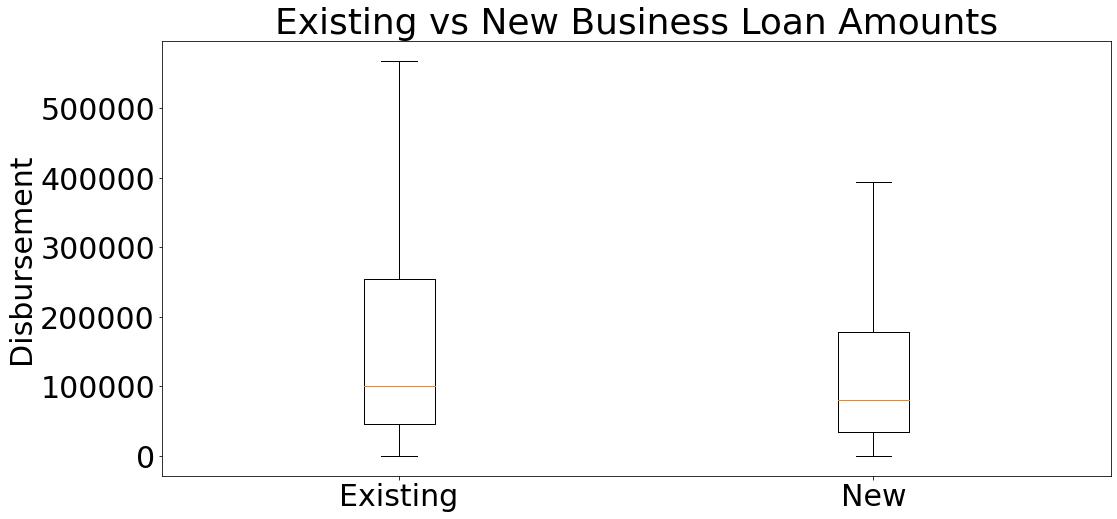

In [11]:
#new vs existing businesses
df_exist = df[df['NewExist'] == 1]
df_new = df[df['NewExist'] == 2]
plt.figure(figsize=[17, 8])
plt.boxplot([df_exist['DisbursementGross'], df_new['DisbursementGross']], showfliers=False)
plt.xticks([1, 2], ['Existing', 'New'])
plt.ylabel('Disbursement')
plt.title('Existing vs New Business Loan Amounts')
plt.rc('font', size=30)
plt.savefig(image_path + 'exist_vs_new_amt.png')

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


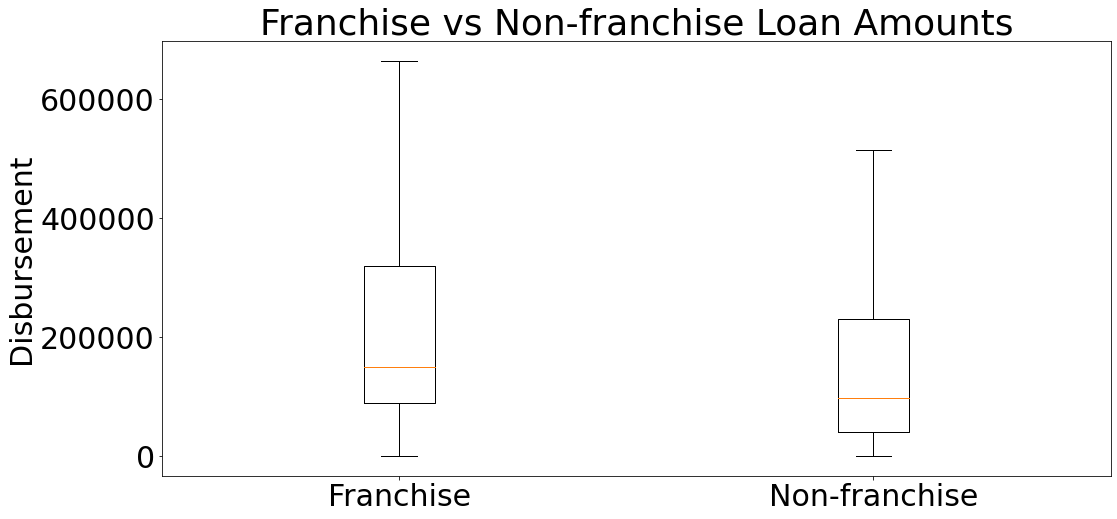

In [12]:
#franchise vs non franchise
df_franchise = df[df['FranchiseCode'] > 1]
df_not_franchise = df[df['FranchiseCode'] <= 1]
plt.figure(figsize=[17, 8])
plt.boxplot([df_franchise['DisbursementGross'], df_not_franchise['DisbursementGross']], showfliers=False)
plt.xticks([1, 2], ['Franchise', 'Non-franchise'])
plt.ylabel('Disbursement')
plt.title('Franchise vs Non-franchise Loan Amounts')
plt.rc('font', size=30)
plt.savefig(image_path + 'franchise_vs_non_amt.png')

In [ ]:
#number of employees vs disbursement
plt.figure(figsize=[23, 8])
plt.scatter(df['NoEmp'], df['DisbursementGross'])
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Number of Employees')
plt.ylabel('Disbursement')
plt.title('No. of Emps. vs Loan Amt.')
plt.rc('font', size=30)
plt.savefig(image_path + 'no_emps_vs_amt.png')
#excluding outliers, most businesses have 20 emps or less, avg 11
#6000 entries have 0 emps though, about half of these are new businesses

In [ ]:
zero_emps = df[df['NoEmp'] == 0]
zero_emps_new = zero_emps[zero_emps['NewExist'] == 2]
zero_emps_new[zero_emps_new['MIS_Status'] == 'CHGOFF']
df_franchise[df_franchise['NoEmp'] == 0]

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


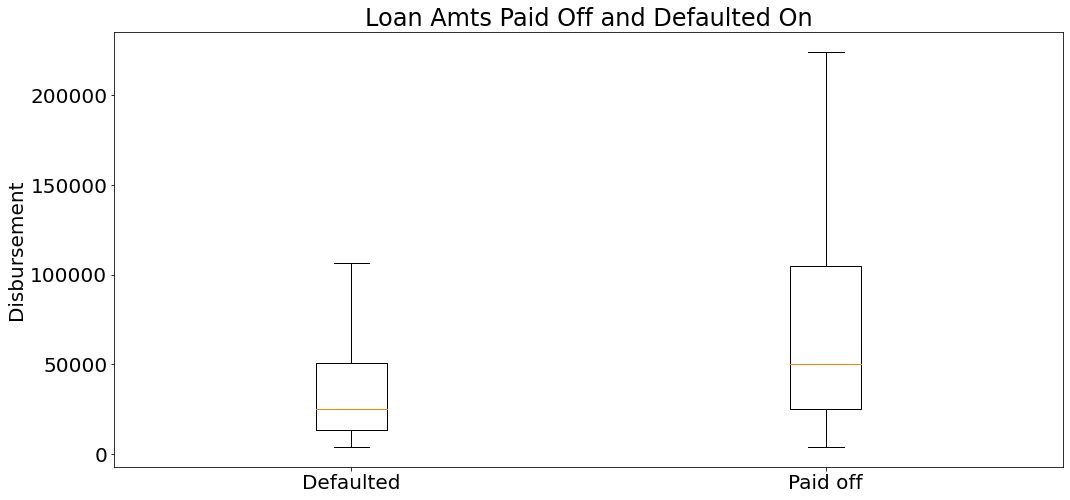

In [78]:
#defaulted vs non-defaulted on loans
df_defaulted = df[df['MIS_Status'] == 0.0]
df_not_defaulted = df[df['MIS_Status'] == 1.0]
plt.figure(figsize=[17, 8])
plt.boxplot([df_defaulted['DisbursementGross'], df_not_defaulted['DisbursementGross']], showfliers=False)
plt.xticks([1, 2], ['Defaulted', 'Paid off'])
plt.ylabel('Disbursement')
plt.title('Loan Amts Paid Off and Defaulted On')
plt.rc('font', size=30)


**Adding a helpful column and deleting a redundant one.**

In [ ]:
df['IsFranchise'] = df['FranchiseCode'] > 1
df.drop('Sector', axis=1, inplace=True)

**Let's try to predict the DisbursementGross a business receives. Predicting a continuous value - use linear regression. Splitting dataset into 70% training, 30% testing.**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
#thinking about which variables to use and their types
# categorical_cols = df[['State', 'Bank', 'BankState', 'ApprovalFY', 'NewExist', 'FranchiseCode', 
#                        'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status']]
# categorical_cols = df[['NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status', 'IsFranchise', 'Sectornum']]
# int_cols = df[['Term', 'NoEmp']]
# float_cols = df[['ChgOffPrinGr', 'GrAppv', 'SBA_Appv']]
# unneeded_cols = df[['Sector', 'Sectornum', 'ID', 'Name', 'City', 'Zip', 'NAICS', 'ApprovalDate', 
#                     'CreateJob', 'RetainedJob', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross']]
df.dropna(inplace=True)
corr = df.corr() ** 2
corr['DisbursementGross']

In [74]:
#building a function to make linear model
def predict_loan_amount(df_categorical, df_not_cat, y):
  df_categorical_fixed = pd.get_dummies(df_categorical)
  df_X_columns = pd.merge(df_categorical_fixed, df_not_cat, left_index=True, right_index=True)
  X = df_X_columns
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  preds = lr.predict(X_test)
  train_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
  test_df = pd.merge(X_test, y_test, left_index=True, right_index=True)
  test_df['Disbursement Preds'] = preds

  plt.figure(figsize=[18, 8])
  plt.scatter(test_df['DisbursementGross'], test_df['Disbursement Preds'])
  plt.ticklabel_format(axis='y', style='plain')
  plt.ticklabel_format(axis='x', style='plain')
  #plt.title(test_df['DisbursementGross'].corr(test_df['Disbursement Preds'])**2)
  plt.xlabel('Actual Loan Amt')
  plt.ylabel('Predicted Loan Amt')
  plt.title('Actual vs Predicted Loan Amount')
  plt.rc('font', size=20)
  z = np.polyfit(test_df['DisbursementGross'], test_df['Disbursement Preds'], 1)
  p = np.poly1d(z)
  plt.plot(test_df['DisbursementGross'], p(test_df['DisbursementGross']))
  #plt.xticks([1, 2], ['Franchise', 'Non-franchise'])

In [ ]:
#after some testing, these variables were the best to use
#creating dfs for categorical and non-categorical variables to use in linear regression function
df_categorical = df[['RevLineCr', 'IsFranchise', 'Description']]
df_not_cat = df['Term']
y = df['DisbursementGross']
predict_loan_amount(df_categorical, df_not_cat, y)